In [ ]:
# Anita Sun

# In this notebook, I:
# write function to gpd.sjoin census tract shapefile polygons with long/lat coordinate information from police homicide
# write function to merge 2013 census tract demographic data with the the gpd sjoined police homicide data

In [20]:
import pandas as pd
import geopandas as gpd
import numpy as np
from preprocess import clean_police_dataset
import shapely
from shapely.geometry import point
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def tract_merger(pol_filepath, shapefile_path):
    ''' 
    takes in the police homicide filepath and the census tract shapefile path
    and merges them together for that particular state

    pol_filepath: (str) file path for the police homicide csv
    shapefile_path: (str) file path for the census tract polygons shapefile

    returns:
    geo_joined_df: (GeoPandas Dataframe) a geopandas dataframe
    '''
    gdf = gpd.read_file(shapefile_path)
    pol_df = clean_police_dataset(pol_filepath)
    pol_df['geometry'] = gpd.points_from_xy(pol_df['longitude'], pol_df['latitude'])
    pol_gdf = gpd.GeoDataFrame(pol_df, geometry='geometry', crs="EPSG:4326")
    geo_joined_df = gpd.sjoin(gdf.to_crs(crs='EPSG:26916'), pol_gdf.to_crs(crs='EPSG:26916'))
    geo_joined_df = geo_joined_df[['GEOIDFQ','name', 'age', 'gender', 'race',
       'date', 'street_address', 'city', 'state', 'zip', 'county',
       'agency_responsible', 'ori', 'cause_of_death', 'circumstances',
       'disposition_official', 'officer_charged', 'news_urls',
       'signs_of_mental_illness', 'allegedly_armed', 'wapo_armed',
       'wapo_threat_level', 'wapo_flee', 'geography', 'encounter_type',
       'initial_reason', 'call_for_service', 'tract',
       'hhincome_median_census_tract', 'latitude', 'longitude',
       'pop_total_census_tract', 'pop_white_census_tract',
       'pop_black_census_tract', 'pop_native_american_census_tract',
       'pop_asian_census_tract', 'pop_pacific_islander_census_tract',
       'pop_other_multiple_census_tract', 'pop_hispanic_census_tract',
       'lat_long', 'month', 'day', 'year']]
    # renaming GEOIDFQ to GEO_ID so we can merge with ACS later
    geo_joined_df.rename(columns={'GEOIDFQ':'GEO_ID'}, inplace=True)
    # correcting year column to dtype int64
    geo_joined_df['year'] = geo_joined_df['year'].astype(int)

    return geo_joined_df

In [3]:
def booleaner(obj, list_like):
    ''' 
    returns 1 if obj is found in list_like, else returns zero
    obj: (anything)
    list_like: (listlike)
    '''
    if obj in list_like:
        return 1
    else:
        return 0

In [4]:
def attr_merger(geo_joined_df, census_file_path, county):
    ''' 
    takes a geo_joined_df and census_file_path. reads census_file_path into a df, then adds a column named 'target' using info from geo_joined_df
    inputs:
        geo_joined_df: (GeoPandasDataFrame) a sjoin of a state's .shp shapefile and the original police homicide csv
            has column 'GEOIDFQ' renamed to 'GEO_ID' for merging;
        census_file_path: file path for census tract demographic information, should be csv containing a merge across 3 diff datasets:
            ACS 5-year estimate on census tract level for survey "S1501", "S1903", "DP05", year = 2013
    county: (str or list of str) county(s) in question, formatted like 'Los Angeles County'
    
    returns:
        df: a pd DataFrame containing census demographic data and a column that contains boolean val for pol homicide
    '''
    df = pd.read_csv(census_file_path)

    # dropping row index zero because it contains column name information and not data
    df = df.drop(index=0, axis=0)

    # converting all possible columns to float for later regression/classification analysis
    for col in df.columns:
        try:
            df[col] = df[col].astype(float)
        except:
            continue

    # extracting county information from the NAME column using regex    
    df['in_county'] = df.NAME.str.extract(r'\s*([\w\s]+ County)', expand=False)
    
    # control flow for selecting only the census tracts within the specified county(s)
    if type(county)==str:
        df = df[df['in_county'] == county]
    if type(county)==list:
        df = df[df['in_county'].isin(county)]        
    df['target'] = df.apply(
		lambda x: booleaner(x['GEO_ID'], geo_joined_df['GEO_ID'].values),
        axis=1
	)

    return df

In [5]:
geo_ny = tract_merger('police_data.csv', 'new_york_shapefiles/tl_2023_36_tract.shp')
geo_il = tract_merger('police_data.csv', 'illinois_shapefiles/tl_2023_17_tract.shp')
geo_ca = tract_merger('police_data.csv', 'california_shapefiles/tl_2023_06_tract.shp')

**Visualizations for police_data.csv**

(0.0, 230.0)

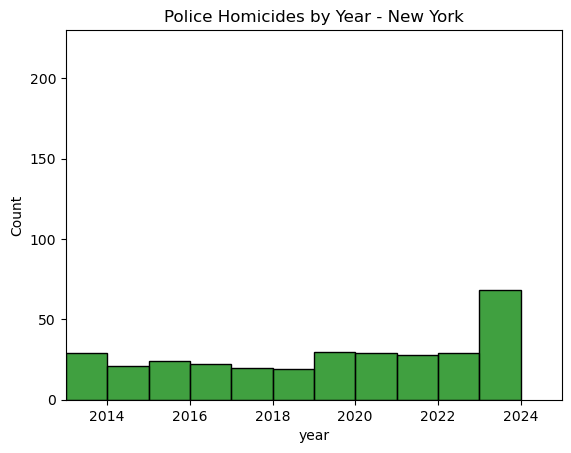

In [65]:
sns.histplot(geo_ny['year'],
             color='g',
             binwidth=1)
plt.title('Police Homicides by Year - New York')
plt.xlim(2013, 2025)
plt.ylim(0, 230)

(0.0, 230.0)

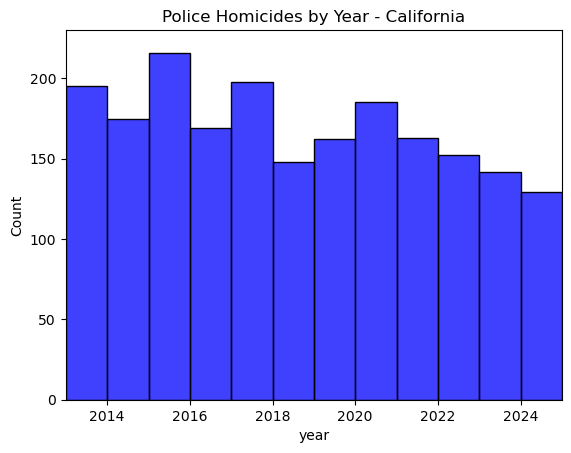

In [68]:
sns.histplot(geo_ca['year'],
             color='b',
             binwidth=1)
plt.title('Police Homicides by Year - California')
plt.xlim(2013, 2025)
plt.ylim(0, 230)

(0.0, 230.0)

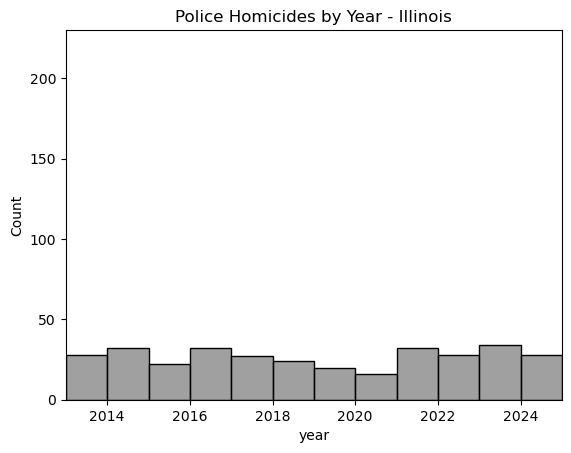

In [69]:
sns.histplot(geo_il['year'],
             color='grey',
             binwidth=1)
plt.title('Police Homicides by Year - Illinois')
plt.xlim(2013, 2025)
plt.ylim(0, 230)

In [ ]:
# performing attr_merger and writing out to csv for other group members to use

df_ny = attr_merger(geo_ny, 'census_2013/ny_2013.csv', county=['Bronx County', 'Kings County', 'New York County', 'Queens County', 'Richmond County'])
df_il = attr_merger(geo_il, 'census_2013/il_2013.csv', county='Cook County')
df_ca = attr_merger(geo_ca, 'census_2013/ca_2013.csv', county='Los Angeles County')

/tmp/ipykernel_25604/3136482841.py:12: DtypeWarning: Columns (2,3,58,59,82,83,124,125,126,127,128,129,154,155,156,157,158,159,214,215,216,217,218,219,232,233,234,235,236,237,250,251,252,253,254,255,268,269,270,271,272,273,354,355,356,358,359,362,363,366,367,370,371,374,375,378,379,382,383,386,387,390,391,394,395,398,399,402,403,406,407,410,411,414,415,422,423,426,427,430,431,434,435,438,439,440,442,443,446,447,450,451,452,454,455,458,459,462,463,464,466,467,470,471,474,475,478,479,482,483,486,487,490,491,494,495,498,499,502,503,506,507,510,511,514,515,518,519,522,523,526,527,530,531,534,535,538,539,542,543,546,547,550,551,554,555,558,559,562,563,566,567,570,571,574,575,578,579,582,583,584,586,587,590,591,594,595,598,599,602,603,606,607,610,611,612,614,615,618,619,622,623,626,627,630,631,634,635,638,639,642,643,646,647,650,651,654,655,658,659,662,663,666,667,670,671,674,675) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(census_file_path)
/t

In [26]:
df_ny.to_csv('final_merge_ny.csv')
df_ca.to_csv('final_merge_ca.csv')
df_il.to_csv('final_merge_il.csv')

In [77]:
# defining feature codebook dictionary

colname_dic = {"S1501_C01_014E": "highschool degree over higher rate", 
               "S1903_C02_001E": "household median income", 
               "S1903_C02_002E": "white household median income",
               "S1903_C02_003E": "black household median income",
               "DP05_0032PE": "white race rate",
               "DP05_0033PE": "black race rate"
               }

In [82]:
# reformatting irregular data entries

df_ny = df_ny[["S1501_C01_014E", "S1903_C02_001E", "S1903_C02_002E", "S1903_C02_003E", "DP05_0032PE", "DP05_0033PE", "target"]]
df_ny.replace(to_replace = {'250,000+': '250000', '2,500-': '2500', '-': np.nan}, inplace=True)
df_il = df_il[["S1501_C01_014E", "S1903_C02_001E", "S1903_C02_002E", "S1903_C02_003E", "DP05_0032PE", "DP05_0033PE", "target"]]
df_il.replace(to_replace = {'250,000+': '250000', '2,500-': '2500', '-': np.nan}, inplace=True)
df_ca = df_ca[["S1501_C01_014E", "S1903_C02_001E", "S1903_C02_002E", "S1903_C02_003E", "DP05_0032PE", "DP05_0033PE", "target"]]
df_ca.replace(to_replace = {'250,000+': '250000', '2,500-': '2500', '-': np.nan}, inplace=True)

In [ ]:
# converting to numeric

merged_states = [df_ca, df_ny, df_il]

for state in merged_states:
    for col in state.columns:
        try:
            state[col] = state[col].astype(float)
        except:
            continue 

**ACS Census Tract Data EDA**

In [84]:
print(f'Desc for New York City', '\n')
for col in colname_dic.keys():
        print(colname_dic[col],'\n',df_ny[col].describe())
        print('\n')

Desc for New York City 

highschool degree over higher rate 
 count    2127.000000
mean       79.528538
std        13.082514
min         0.000000
25%        71.500000
50%        82.000000
75%        89.300000
max       100.000000
Name: S1501_C01_014E, dtype: float64


household median income 
 count      2109.000000
mean      57709.096728
std       28060.803932
min        9959.000000
25%       37981.000000
50%       52841.000000
75%       71750.000000
max      250000.000000
Name: S1903_C02_001E, dtype: float64


white household median income 
 count      1993.000000
mean      59747.228299
std       32319.388117
min        4596.000000
25%       37214.000000
50%       54432.000000
75%       77143.000000
max      250000.000000
Name: S1903_C02_002E, dtype: float64


black household median income 
 count      1464.000000
mean      51019.962432
std       29300.472517
min        2500.000000
25%       30779.250000
50%       44814.500000
75%       65519.250000
max      250000.000000
Name: S1903

In [85]:
print(f'Desc for Los Angeles', '\n')
for col in colname_dic.keys():
        print(colname_dic[col],'\n',df_ca[col].describe())
        print('\n')

Desc for Los Angeles 

highschool degree over higher rate 
 count    2328.000000
mean       74.938617
std        18.618493
min         0.000000
25%        60.300000
50%        78.450000
75%        91.700000
max       100.000000
Name: S1501_C01_014E, dtype: float64


household median income 
 count      2312.000000
mean      60706.065311
std       30067.020021
min       10290.000000
25%       38696.750000
50%       54137.000000
75%       75015.000000
max      227014.000000
Name: S1903_C02_001E, dtype: float64


white household median income 
 count      2306.000000
mean      61710.753252
std       30565.489775
min       10368.000000
25%       39574.750000
50%       54923.000000
75%       76673.750000
max      233333.000000
Name: S1903_C02_002E, dtype: float64


black household median income 
 count      1405.000000
mean      53991.232740
std       39362.120201
min        2500.000000
25%       26875.000000
50%       44844.000000
75%       67765.000000
max      250000.000000
Name: S1903_C

In [86]:
print(f'Desc for Chicago', '\n')
for col in colname_dic.keys():
        print(colname_dic[col],'\n',df_il[col].describe())
        print('\n')

Desc for Chicago 

highschool degree over higher rate 
 count    1315.000000
mean       83.218403
std        13.001100
min        29.100000
25%        75.850000
50%        86.400000
75%        93.500000
max       100.000000
Name: S1501_C01_014E, dtype: float64


household median income 
 count      1315.000000
mean      56258.679087
std       28395.446593
min        5725.000000
25%       36348.500000
50%       51250.000000
75%       70592.500000
max      231875.000000
Name: S1903_C02_001E, dtype: float64


white household median income 
 count      1134.000000
mean      65150.330688
std       30361.879649
min        2500.000000
25%       44707.000000
50%       58965.500000
75%       80274.250000
max      250000.000000
Name: S1903_C02_002E, dtype: float64


black household median income 
 count       869.000000
mean      41633.201381
std       29142.975107
min        2500.000000
25%       22582.000000
50%       34207.000000
75%       51342.000000
max      250000.000000
Name: S1903_C02_0

**Target variable Distribution and Balance**

In [71]:
# checking distribution of target column
print('New York')
print(df_ny['target'].value_counts())
print('\n')
print('Los Angeles')
print(df_ca['target'].value_counts())
print('\n')
print('Chicago')
print(df_il['target'].value_counts())

New York
target
0    2048
1     119
Name: count, dtype: int64


Los Angeles
target
0    1944
1     402
Name: count, dtype: int64


Chicago
target
0    1185
1     134
Name: count, dtype: int64
